In [1]:
%%capture
# Installs Unsloth, Xformers (Flash Attention) and all other packages!
!pip install "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"

# We have to check which Torch version for Xformers (2.3 -> 0.0.27)
from torch import __version__; from packaging.version import Version as V
xformers = "xformers==0.0.27" if V(__version__) < V("2.4.0") else "xformers"
!pip install --no-deps {xformers} trl peft accelerate bitsandbytes triton

# **Preprocessing**

If you are using the original csv data, this cell is used to get the desired json format for model training.

In [3]:
import csv
import json

# File paths
csv_file = 'train_test_network.csv'
jsonl_file = 'train_test_network.jsonl'

with open(csv_file, 'r') as f, open(jsonl_file, 'w') as jsonl_f:
    reader = csv.DictReader(f)

    for row in reader:
        # Normalize the label to ensure comparison is case-insensitive
        label_field = row['type'].strip().lower()

        # Determine if the connection is an attack or normal
        label = 'normal' if label_field == 'normal' else 'attack'

        # Construct the user message by concatenating all relevant fields
        user_message = ", ".join([f"{key}: {value}" for key, value in row.items() if key != 'label' and key != 'type'])

        # Create the conversation in the desired format
        conversation = {
            "conversations": [
                {"from": "human", "value": user_message},
                {"from": "gpt", "value": label}
            ]
        }

        # Write each conversation as a JSON object in a new line
        jsonl_f.write(json.dumps(conversation) + "\n")

# **Load Model**

In [4]:
from unsloth import FastLanguageModel
import torch

samples = 1000
max_seq_length = 2048
dtype = None
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.

# Load the model. Need for tokenizer.
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/Phi-3.5-mini-instruct",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
==((====))==  Unsloth 2024.8: Fast Llama patching. Transformers = 4.44.2.
   \\   /|    GPU: Tesla T4. Max memory: 14.748 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.4.0+cu121. CUDA = 7.5. CUDA Toolkit = 12.1.
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.28. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/2.26G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/140 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/3.37k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

# **Split the data into test, train and evaluation sets**


In [5]:
import torch
from unsloth.chat_templates import get_chat_template

tokenizer = get_chat_template(
    tokenizer,
    chat_template = "phi-3",
    mapping = {"role" : "from", "content" : "value", "user" : "human", "assistant" : "gpt"}, # ShareGPT style
)

def formatting_prompts_func(examples):
    convos = examples["conversations"]
    texts = [tokenizer.apply_chat_template(convo, tokenize = False, add_generation_prompt = False) for convo in convos]
    return { "text" : texts, }
pass

In [6]:
from datasets import load_dataset
from sklearn.model_selection import train_test_split

#Files located in google colab gpu instance,
file_path = f'/content/{jsonl_file}'
dataset = load_dataset('json', data_files=file_path, split='train')

# Split the dataset
split_dataset = dataset.train_test_split(test_size=0.2)  # 20% test data

# Access the training and testing splits
train_dataset = split_dataset['train']
test_dataset = split_dataset['test']

# Further split the training dataset into train and validation sets
train_split = train_dataset.train_test_split(test_size=0.2)  # 20% test data

# Access the new splits
train_dataset = train_split['train']
eval_dataset = train_split['test']

train_dataset = train_dataset.map(formatting_prompts_func, batched = True,)
eval_dataset = eval_dataset.map(formatting_prompts_func, batched = True,)
test_dataset = test_dataset.map(formatting_prompts_func, batched = True,)

Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/135067 [00:00<?, ? examples/s]

Map:   0%|          | 0/33767 [00:00<?, ? examples/s]

Map:   0%|          | 0/42209 [00:00<?, ? examples/s]

In [7]:
import time
import sys

def evaluate_model_on_dataset(model, tokenizer, test_dataset, num_samples):

    # Enable native 2x faster inference
    FastLanguageModel.for_inference(model)

    # List to store predictions
    predictions = []
    ground_truths = []
    start_time = time.time()

    # Metrics
    correct = 0
    incorrect = 0
    accuracy = 0

    prompt = "Given the following network data, classify the traffic as either 'attack' or 'normal' with a single word:\n\n"
    print(f"Prompt: {prompt}")

    # Function to map incomplete answers to full words (e.g attac or norm)
    def complete_prediction(pred):
        if pred.lower().startswith('a'):
            return "attack"
        elif pred.lower().startswith('n'):
            return "normal"
        else:
            return pred  # Return as is if it doesn't start with 'a' or 'n'

    # Loop over each item in the test dataset
    for item in test_dataset.select(range(num_samples)):

        # Extract the human input from the item
        human_input = item['conversations'][0]['value']

        # Prepare messages with the current input
        message = [{"from": "human", "value": f"{prompt}{human_input}"}]

        # Tokenize the input
        inputs = tokenizer.apply_chat_template(
            message,
            tokenize=True,
            add_generation_prompt=True,  # Must add for generation
            return_tensors="pt",
        ).to("cuda")

        # Generate the output
        outputs = model.generate(input_ids=inputs, max_new_tokens=1, use_cache=True)
        answer = tokenizer.batch_decode(outputs)

        # Process the prediction
        pred = complete_prediction(answer[0].split()[-1])
        truth = item['conversations'][1]['value'].strip()

        # Append predictions and truths
        predictions.append(pred)
        ground_truths.append(truth)

        # Update metrics
        if pred == truth:
            correct += 1
            color_code = "\033[32m"  # Green
        else:
            incorrect += 1
            color_code = "\033[31m"  # Red

        # Calculate accuracy
        elapsed_time = time.time() - start_time
        accuracy = (correct / (correct + incorrect)) * 100

        # Print current status
        sys.stdout.write(f"\rElapsed Time: {elapsed_time:.2f} seconds, Accuracy: {accuracy:.2f}%, Completed: {correct + incorrect}/{num_samples} Prediction: {color_code}{pred}\033[0m, Ground Truth: {color_code}{truth}\033[0m")
        sys.stdout.flush()

    print("\n\n\nInference Complete\n\n\n")

    return predictions, ground_truths

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import numpy as np
import pandas as pd

def metrics(predictions, ground_truths):
    # Convert to numpy arrays
    y_true = np.array(ground_truths)
    y_pred = np.array(predictions)

    # Convert string labels to numeric values
    label_mapping = {'attack': 1, 'normal': 0}
    y_true_numeric = np.array([label_mapping[label] for label in y_true])
    y_pred_numeric = np.array([label_mapping[label] for label in y_pred])

    accuracy = accuracy_score(y_true, y_pred)*100
    print(f"Accuracy: {accuracy:.2f}%\n")

    # Print classification report
    class_report = classification_report(y_true, y_pred, labels=['attack', 'normal'])
    print("Classification Report:")
    print(class_report, '\n')

    # Compute metrics
    precision = precision_score(y_true, y_pred, average=None, labels=['attack', 'normal'])
    recall = recall_score(y_true, y_pred, average=None, labels=['attack', 'normal'])
    f1 = f1_score(y_true, y_pred, average=None, labels=['attack', 'normal'])

    metrics_df = pd.DataFrame({
        'Class': ['attack', 'normal'],
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    })

    # Create subplots
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))  # Two plots side by side

    # Plot precision, recall, and F1 score
    metrics_df.plot(x='Class', kind='bar', ax=axes[0])
    axes[0].set_title('Precision, Recall, and F1 Score by Class')
    axes[0].set_xlabel('Class')
    axes[0].set_ylabel('Score')
    axes[0].set_ylim(0, 1)

    # Plot confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=['attack', 'normal'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['attack', 'normal'], yticklabels=['attack', 'normal'], ax=axes[1])
    axes[1].set_xlabel('Predicted')
    axes[1].set_ylabel('True')
    axes[1].set_title('Confusion Matrix')

    # Adjust layout
    plt.subplots_adjust(wspace=0.3)
    plt.show()


## **Fine-Tuning**

**Fine-Tuning the Phi 3 Model for Cybersecurity Data Labeling**

In this notebook, we are fine-tuning the Phi 3 model to enhance its performance in cybersecurity data labeling tasks. Although the Phi 3 model is powerful, it is initially pre-trained on general text data, which may not fully capture the specific patterns and nuances present in cybersecurity datasets. Through fine-tuning, we aim to adapt the model to the unique characteristics of our data, enabling it to more effectively distinguish between normal network traffic and potential threats.

Fine-tuning is a critical step in ensuring that the model is well-suited to the specific challenges of our data labeling project, leading to more accurate and reliable predictions, which are crucial for effective intrusion detection.

We are using Unsloth, a specialized tool designed to optimize and streamline the fine-tuning process for large language models. Unsloth allows us to efficiently manage and apply the necessary transformations and templates that align the model's training with our specific objectives in cybersecurity. By leveraging Unsloth, we can customize the fine-tuning process, making it more effective and tailored to our needs.

Using Unsloth ensures that the fine-tuning process is not only faster but also more closely aligned with the demands of our project, ultimately leading to better results in our intrusion detection tasks.

In [9]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 128, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 10,
    lora_dropout = 0.1, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    # [NEW] "unsloth" uses 30% less VRAM, fits 2x larger batch sizes!
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context
    random_state = 3407,
    use_rslora = True,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
)

Unsloth: Dropout = 0 is supported for fast patching. You are using dropout = 0.1.
Unsloth will patch all other layers, except LoRA matrices, causing a performance hit.
Unsloth 2024.8 patched 32 layers with 0 QKV layers, 0 O layers and 0 MLP layers.


# **Set model parameters**

In [10]:
from trl import SFTTrainer
from transformers import TrainingArguments

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = train_dataset,
    eval_dataset = eval_dataset,
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    dataset_num_proc = 2,
    packing = False, # Packs short sequences together to save time!
    args = TrainingArguments(
        per_device_train_batch_size = 8,
        gradient_accumulation_steps = 16,
        warmup_steps = 5,
        max_steps = 80,
        num_train_epochs=3,
        learning_rate = 1e-5,
        fp16 = not torch.cuda.is_bf16_supported(),
        bf16 = torch.cuda.is_bf16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.1,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
    ),
)

Map (num_proc=2):   0%|          | 0/135067 [00:00<?, ? examples/s]

Map (num_proc=2):   0%|          | 0/33767 [00:00<?, ? examples/s]

max_steps is given, it will override any value given in num_train_epochs


# **Train Model**

In [11]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 135,067 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 8 | Gradient Accumulation steps = 16
\        /    Total batch size = 128 | Total steps = 80
 "-____-"     Number of trainable parameters = 239,075,328


Step,Training Loss
1,1.438900
2,1.450900
3,1.444400
4,1.447100
5,1.392100
6,1.363500
7,1.317200
8,1.298000
9,1.260900
10,1.221000


# **Run inference on test data**

In [12]:
# Call the evaluation function
pred, truth = evaluate_model_on_dataset(model, tokenizer, test_dataset, num_samples=samples)

Prompt: Given the following network data, classify the traffic as either 'attack' or 'normal' with a single word:




The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Elapsed Time: 486.29 seconds, Accuracy: 44.50%, Completed: 1000/1000 Prediction: normal, Ground Truth: attack


Inference Complete





Accuracy: 44.50%

Classification Report:
              precision    recall  f1-score   support

      attack       0.86      0.31      0.45       749
      normal       0.29      0.85      0.44       251

    accuracy                           0.45      1000
   macro avg       0.58      0.58      0.44      1000
weighted avg       0.72      0.45      0.45      1000
 



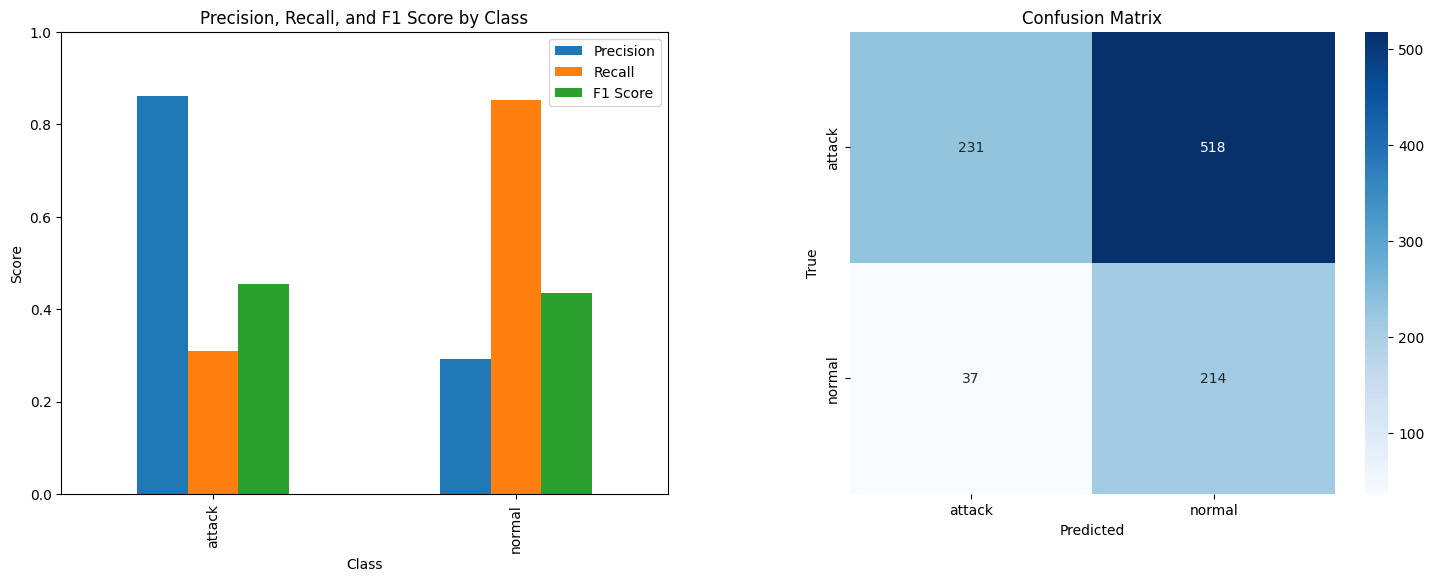

In [13]:
metrics(pred, truth)